# Regression diagnostics:  testing the assumptions of linear regression

In [80]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

In [89]:
data = pd.read_csv('E:\singapore\data\preprocessed_data.csv')
data = data.drop(columns=['Unnamed: 0'], axis=1)
data_copy = data.copy()
data.head(1)

,month,flat_type,storey_range,resale_price,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard,floor_area_sqm,lease_commence_date,remaining_lease,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri
0,2018-01,0,3,250000.0,0,0,0,0,0,1,-2.189207,-1.246874,-1.177124,-0.094986,0.156198,-0.850555,-0.837559,0.726098


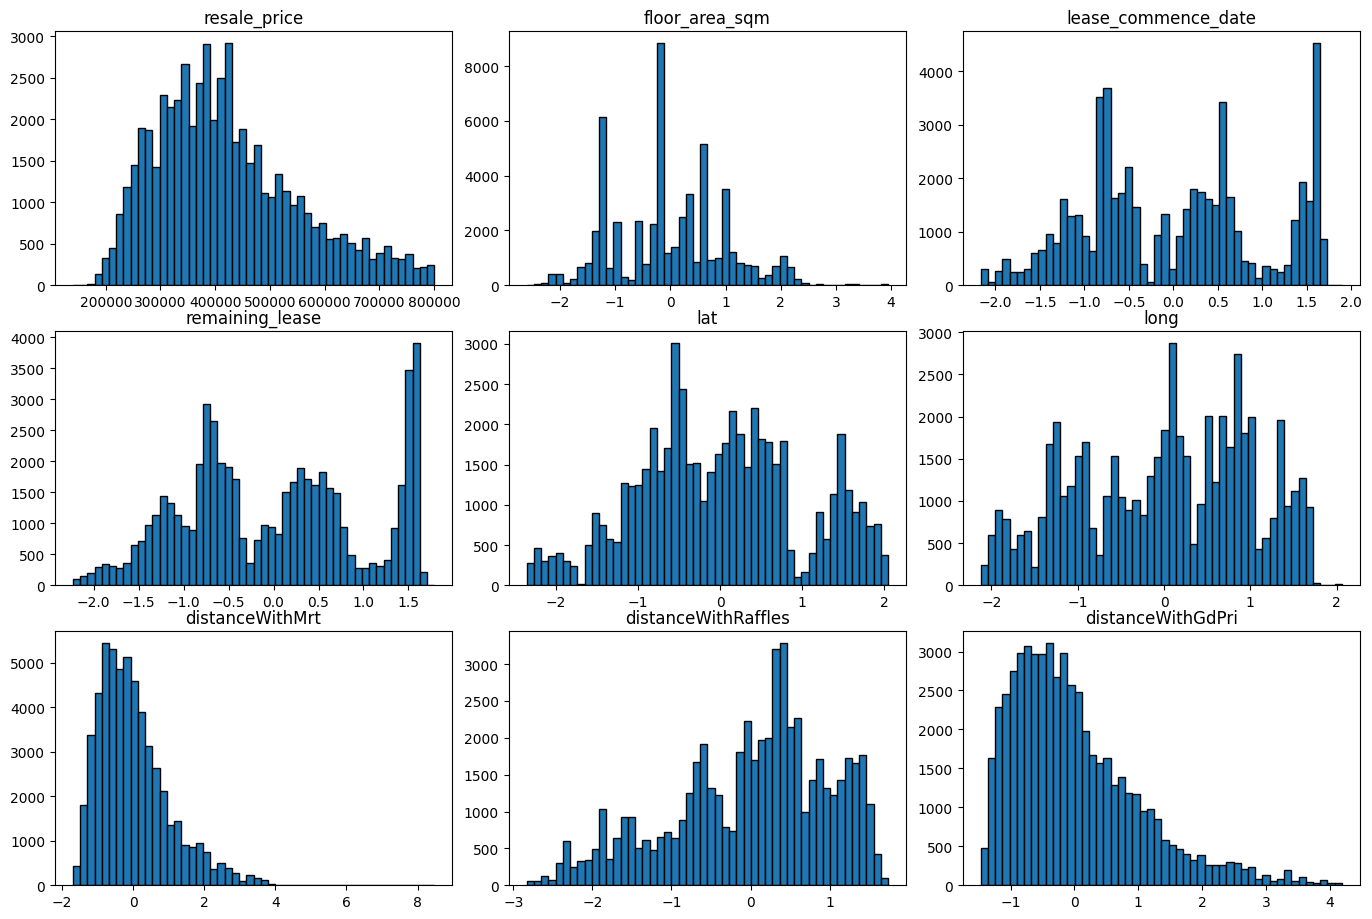

In [56]:
data_copy_1 = data[['resale_price', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'lat','long',
     'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri']]
data_copy_1.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

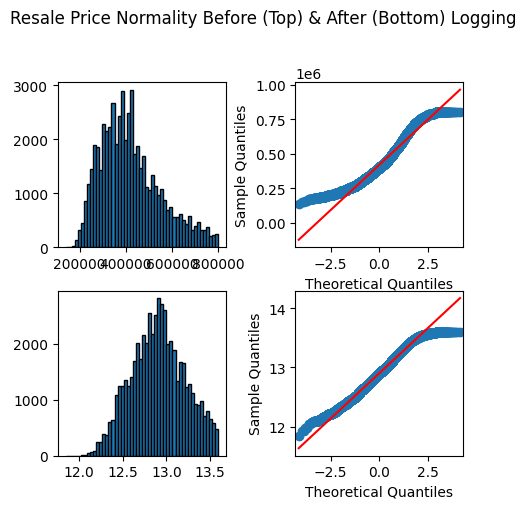

In [58]:
# do biểu đồ phân phối của resale_price lệch sang trái nên dùng log transformation để đưa về dạng pp chuẩn
# plot qqplot before and after log transformation => nên đưa vào model giá trị log của y

from statsmodels.api import qqplot
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(data['resale_price'], bins=50, edgecolor='black')
qqplot(data['resale_price'], line='s', ax=ax2)
ax3.hist(np.log(data['resale_price']), bins=50, edgecolor='black')
qqplot(np.log(data['resale_price']), line='s', ax=ax4)
plt.suptitle('Resale Price Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

In [92]:
# multicolinearlity

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(data.drop('resale_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,3.806990,0.262675,39.974978
1,storey_range,2.763306,0.361885,39.974978
2,model_Apartment,1.472929,0.678919,39.974978
3,model_Maisonette,1.255341,0.796597,39.974978
4,model_New Generation,1.500049,0.666645,39.974978
5,model_Special,1.042516,0.959218,39.974978
6,floor_area_sqm,1.950084,0.512798,39.974978
7,lease_commence_date,267.882829,0.003733,39.974978
8,remaining_lease,268.007652,0.003731,39.974978
9,lat,2.920597,0.342396,39.974978


In [91]:
# observing the features, i saw the features that will be mentioned are remaining_lease, lease_commence_date, model_Model A,
# model_Standard, flat_type, model_Apartment, floor_area_sqm are considered to eliminate
data = data.drop(columns=['model_Model A', 'model_Standard'], axis =1)

In [87]:
# data = data.drop(columns=['model_Standard','model_Model A'], axis=1)

### * significance relationship between the independent variables and the dependent variable (whether model existed or not)

In [93]:
Y = data['resale_price']
X = data[['flat_type', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'lat', 'long'
          , 'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri']]

In [94]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# vì Prob (F-statistic) = 0.00 < 5% nên model tồn tại. Hay nói cách khác với mức ý nghĩa 5% có thể kết luận 
# có ít nhất 1 trong 10 biến X có tác động đến Y

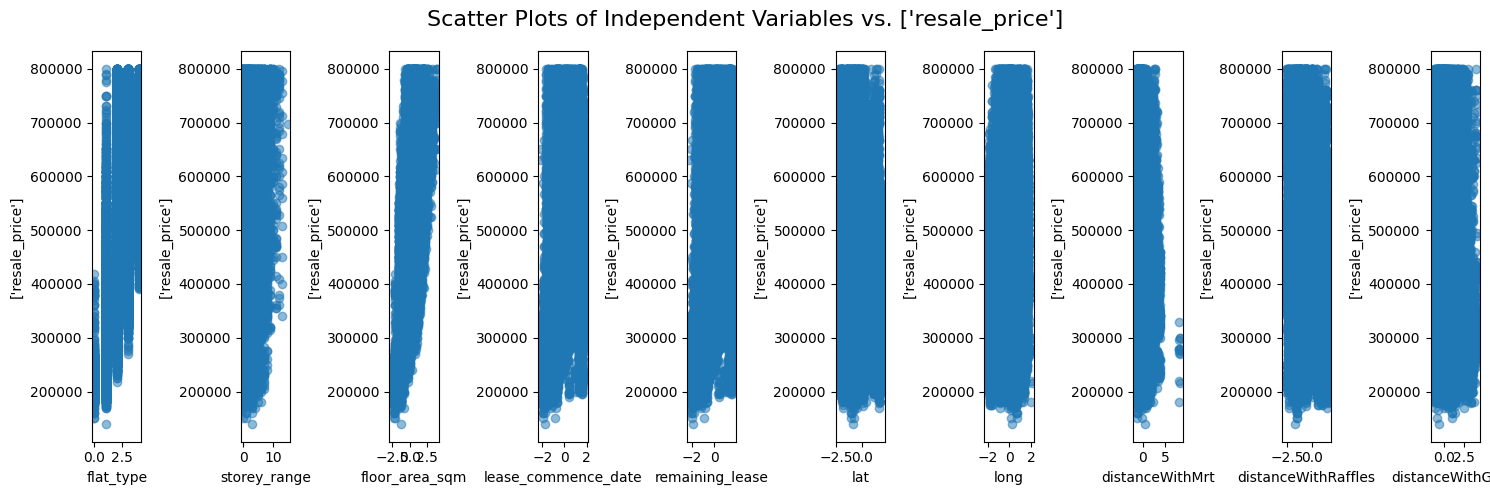

In [35]:
independent_vars = ['flat_type', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'lat', 'long'
          , 'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri']
dependent_var = ['resale_price']

num_subplots = len(independent_vars)
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# Loop through the independent variables and create scatter plots
for i, var in enumerate(independent_vars):
    axes[i].scatter(data[var], data[dependent_var], alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(dependent_var)

# Set a common title for all subplots
fig.suptitle(f'Scatter Plots of Independent Variables vs. {dependent_var}', fontsize=16)

plt.tight_layout()
plt.show()

In [70]:
# phần dư có phân phối chuẩn
model = sm.OLS(Y, X).fit()

# Get the residuals
residuals = model.resid


In [71]:
jb_statistic = sm.stats.jarque_bera(residuals)

# Extract the Jarque-Bera statistic and its associated p-value
jb_test_statistic = jb_statistic[0]
jb_p_value = jb_statistic[1]

# Display the Jarque-Bera statistic and its p-value
print(f"Jarque-Bera Statistic for Residuals: {jb_test_statistic}")
print(f"P-Value for Residuals: {jb_p_value}")

# Check the significance level (commonly 0.05)
alpha = 0.05

# Compare the Jarque-Bera statistic to the critical value
if jb_p_value < alpha:
    print("Reject the null hypothesis: Residuals are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Residuals follow a normal distribution.")

Jarque-Bera Statistic for Residuals: 13717.012889398113
P-Value for Residuals: 0.0
Reject the null hypothesis: Residuals are not normally distributed.


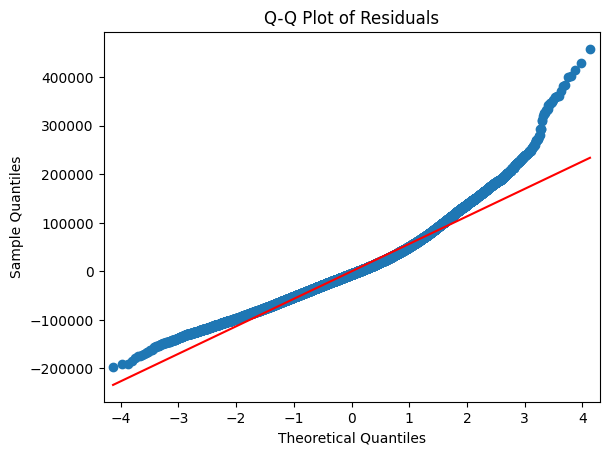

In [73]:
sm.qqplot(residuals, line='s')  # 's' for standard normal distribution line
plt.title('Q-Q Plot of Residuals')
plt.show()

In [75]:
# kỳ vọng toán ( trung bình ) của phần dư
# Calculate the mean and standard error of the residuals
mean_residual = residuals.mean()
se_residual = stats.sem(residuals)
print(mean_residual)

# Define the null hypothesis and the test statistic
null_hypothesis = 0  # The null hypothesis is that the mean of the residuals is zero
t_statistic = (mean_residual - null_hypothesis) / se_residual

# Define the significance level (commonly 0.05)
alpha = 0.05

# Perform the one-sample t-test
t_critical = stats.t.ppf(1 - alpha / 2, df=len(residuals) - 1)  # Calculate the critical t-value

p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=len(residuals) - 1))

# Compare the test statistic to the critical t-value
if abs(t_statistic) > t_critical:
    print(f"Reject the null hypothesis: Mean of residuals is significantly different from {null_hypothesis}.")
else:
    print(f"Fail to reject the null hypothesis: Mean of residuals is not significantly different from {null_hypothesis}.")

# Display the p-value
print(f"P-Value: {p_value}")

Fail to reject the null hypothesis: Mean of residuals is not significantly different from 0.
P-Value: 0.9999999999991043


In [76]:
dw_statistic = durbin_watson(residuals)

# Display the Durbin-Watson statistic
print(f"Durbin-Watson Statistic: {dw_statistic}")

# Interpret the Durbin-Watson statistic
# Rule of thumb: If the statistic is close to 2, there is no significant autocorrelation. 
# Values significantly less than 2 suggest positive autocorrelation, while values significantly greater than 2 suggest negative autocorrelation.
if dw_statistic < 1.5:
    print("Positive autocorrelation may be present.")
elif dw_statistic > 2.5:
    print("Negative autocorrelation may be present.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson Statistic: 0.9052309746761081
Positive autocorrelation may be present.


In [77]:
from sklearn.linear_model import LinearRegression

# sklearn method, which doesn't give much additional info

lin_reg = LinearRegression()
lin_reg.fit(X, np.log(Y))

print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, np.log(Y))}')

Coefficients: [ 0.          0.02726317  0.0267505   0.21667498  0.06645042  0.06829336
 -0.0431565   0.0172349  -0.05318219 -0.11678411 -0.00473865]
Intercept: 12.7907690142251
R^2 score: 0.8525492770137946


In [78]:
import statsmodels.api as sm
# alternate way using statistical formula, which does not require dummy coding manually
# https://stackoverflow.com/questions/50733014/linear-regression-with-dummy-categorical-variables
# https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(np.log(Y),X_constant).fit()
lin_reg.summary()

#use log transformation to make skewed original data more normalize 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 3.206e+04
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:21:52   Log-Likelihood:                 39856.
No. Observations:               55452   AIC:                        -7.969e+04
Df Residuals:                   55441   BIC:                        -7.959e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7908      0.004   3235.274      0.000      12.783      12.799
flat_type               0.0273      0.002     14.658      0.000       0.024       0.031
storey_range            0.0268      0.000     87.382      0.000       0.026       0.027
floor_area_sqm          0.2167      0.002    126.369      0.000       0.213       0.220
lease_commence_date     0.0665      0.008      8.111      0.000       0.050       0.083
remaining_lease         0.0683      0.008      8.331      0.000       0.052       0.084
lat                    -0.0432      0.001    -50.385      0.000      -0.045      -0.041
long                    0.0172      0.001     28.826      0.000       0.016       0.018
distanceWithMrt        -0.0532      0.001   -102.732      0.000      -0.054      -0.052
distanceWithRaffles    -0.1168      0.001   -124.051      0.000      -0.119      -0.115
distanceWithGdPri      -0.0047      0.001     -9.275      0.000      -0.006      -0.004
==============================================================================
Omnibus:                     3769.347   Durbin-Watson:                   0.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8273.236
Skew:                           0.448   Prob(JB):                         0.00
Kurtosis:                       4.667   Cond. No.                         79.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""